I added fiber analysis results for more eyes. These preliminary results contain fiber analysis results for 

(Previous data)
- 9-1 LE INF
- 9-1 RE INF

(New Data)
- 9-1 RE INF
- 9-1 RE SUP
- 11-3 LE INF
- 11-3 LE SUP
- 11-3 RE INF
- 11-3 RE SUP

# Results combining left and right eyes

That is, when splitting data by INF/SUP, ROI, or layer, the results for both eyes are combined. I expect the results to be somewhat skewed if there is indeed a difference in the collagen fiber properties between control (left eyes) and myopic eyes (right eyes)

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import cv2
import scipy

# Make the plots appear inline 
%matplotlib inline
# Make the plots interactive
#%matplotlib notebook

plt.rc('text', usetex=False)

file_name = r'ca_results_11-17-20_full_image.csv' # Updated to compute angle relative to sclera boundary

in_data = pd.read_csv(file_name) # read in the data

pix_to_um = 0.512 # the SHG images have a resolution of 0.512um/pixel 

# Convert the length and width values to microns
in_data['Length'] *= pix_to_um
in_data['Width'] *= pix_to_um

# Use the absolute values of the fiber angle. It's really only meaningful between -90 to 90 degrees
# Should no longer be necessary, assuming the data were compiled using 
# 'compute_ca_roi_stats'
# in_data['Angle'] = np.abs(in_data['Angle'])

in_data.describe() # A summary of the data

,ROI,Layer,Angle,Width,Length,Straightness
count,8354.000000,8354.000000,8354.000000,8354.000000,8354.000000,8354.000000
mean,3.936438,2.552550,-33.874652,2.931153,50.326205,0.932340
std,2.383732,1.125195,36.410392,0.790644,49.648243,0.051275
min,1.000000,1.000000,-89.869752,1.012260,15.360307,0.178281
25%,2.000000,2.000000,-74.418725,2.352991,21.100399,0.915385
50%,3.000000,3.000000,-10.747480,2.862694,32.220797,0.946055
75%,5.000000,4.000000,-0.723361,3.418767,58.959456,0.965620
max,10.000000,4.000000,60.535477,6.960053,583.532542,0.999475


There's not a whole lot of meaningful information there. None of the data is divided into region, ROI, or layer. It does tell us that there are a total of 2758 data points, though. Which is something.

In [4]:
in_data.drop(['Eye'],axis=1) # Don't differentiate results based on eye, for now
in_data.head() # Look at the first 5 rows, in part to get the column labels

,Eye,Region,ROI,Layer,Angle,Width,Length,Straightness
0,LE,INF,1,1,6.210755,2.569035,17.233433,0.921480
1,LE,INF,1,1,-51.450484,4.148817,19.663612,0.957404
2,LE,INF,1,1,-84.554696,3.393260,80.827148,0.966920
3,LE,INF,1,1,-62.667811,2.644009,56.309809,0.917988
4,LE,INF,1,1,-47.518009,2.943134,47.403345,0.940673


Before going any further, I put the images that contain the ROI segments overlaid on the SHG images within the folder. Note these are for eye 9-1_LE, both Inf and Sup scans. 

In [5]:
# im_fid_inf = r'.\Inf_ROI_seg_plot.png'
# im_fid_sup = r'.\Sup_ROI_seg_plot.png'

# inf_im = cv2.imread(im_fid_inf)
# sup_im = cv2.imread(im_fid_sup)

# # cv2 uses BGR ordering whereas pyplot imshow() uses RGB
# inf_im = cv2.cvtColor(inf_im,cv2.COLOR_BGR2RGB)
# sup_im = cv2.cvtColor(sup_im,cv2.COLOR_BGR2RGB)

# # Display the images
# this_fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
# ax1.imshow(inf_im)
# ax2.imshow(sup_im)
# ax1.set_title(r'Inferior')
# ax2.set_title(r'Superior')

The above figure should be interactive, limited to resizing and zooming. Either way, once can see that the inferior region was divided into four distinct 1mm long ROIs whereas the superior region was divided into only three ROIs. 
Note: during the creation of the ROIs, I can define any size I want for the ROI. I went with 1mm here in large part because it reduces the amount of manual preprocessing I have to do after this step, which is defining the sclera boundaries for each ROI image.

Layers are numbered 1-4, with layer 1 being the innermost layer (i.e., layer 4 is posterior)

The following two images are the first (i.e, closest to ONH) ROI for the inferior and superior regions.

In [6]:
# inf_roi_1 = r'9-1_LE_253_INF_MedZoom_ROI-1.tif'
# sup_roi_1 = r'9-1_LE_253_SUP_MedZoom_ROI-1.tif'

# roi_inf = cv2.imread(inf_roi_1)
# roi_sup = cv2.imread(sup_roi_1)

# roi_inf = cv2.cvtColor(roi_inf,cv2.COLOR_BGR2RGB)
# roi_sup = cv2.cvtColor(roi_sup,cv2.COLOR_BGR2RGB)

# roi_fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
# ax1.imshow(roi_inf)
# ax2.imshow(roi_sup)
# ax1.set_title('Inferior, ROI 1')
# ax2.set_title('Superior, ROI 1')

Okay, now I can start looking at the fiber characteristics. The CT-FIRE analysis gives estimates of fiber angle, length, width, and straightness. As of now, the angle is relative to the image boundary, not the sclera boundary, making the magnitude meaningless for now. I can get the angle relative to the sclera boundary, I just haven't written the code yet to extract that information.

Anyway, there are a whole bunch of ways to split up the data. I can look at it per region (INF vs SUP), by ROI or layer, or any combination of the three. Let's start simple.

Text(0, 0.5, 'Straightness')

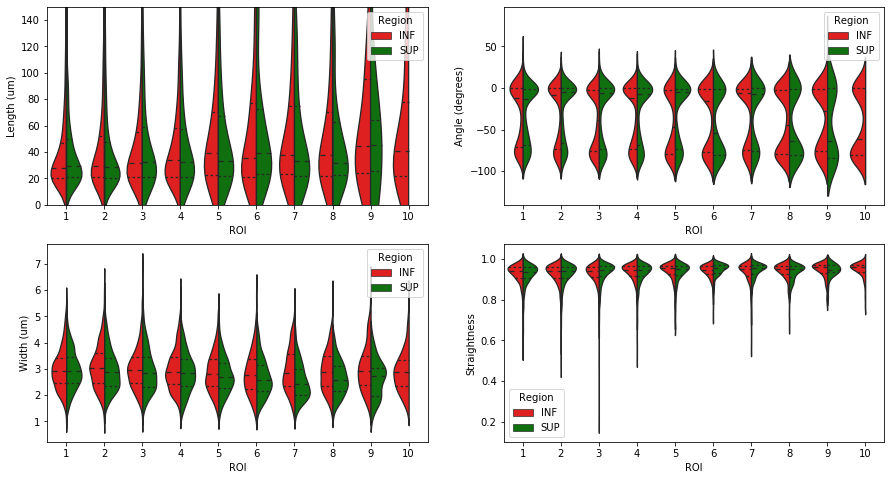

In [7]:
# I'm going to create a violin plot to show the distributions of the
# the fiber parameter estimates by ROI, where the left side of the 'violin' corresponds to the inferior region and
# the right side is the superior region
# To this end, label the data frames
v_fig, ax = plt.subplots(2,2,figsize=(15,8))
sns.violinplot(x="ROI", y="Length", hue="Region", 
               data=in_data, split=True, inner="quart", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[0,0])
ax[0,0].set_ylabel('Length (um)')
ax[0,0].set_ylim([0, 150])

sns.violinplot(x="ROI", y="Angle", hue="Region", 
               data=in_data, split=True, inner="quart", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[0,1])
ax[0,1].set_ylabel('Angle (degrees)')

sns.violinplot(x="ROI", y="Width", hue="Region", 
               data=in_data, split=True, inner="quart", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[1,0])
ax[1,0].set_ylabel('Width (um)')

sns.violinplot(x="ROI", y="Straightness", hue="Region", 
               data=in_data, split=True, inner="quart", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[1,1])
ax[1,1].set_ylabel('Straightness')

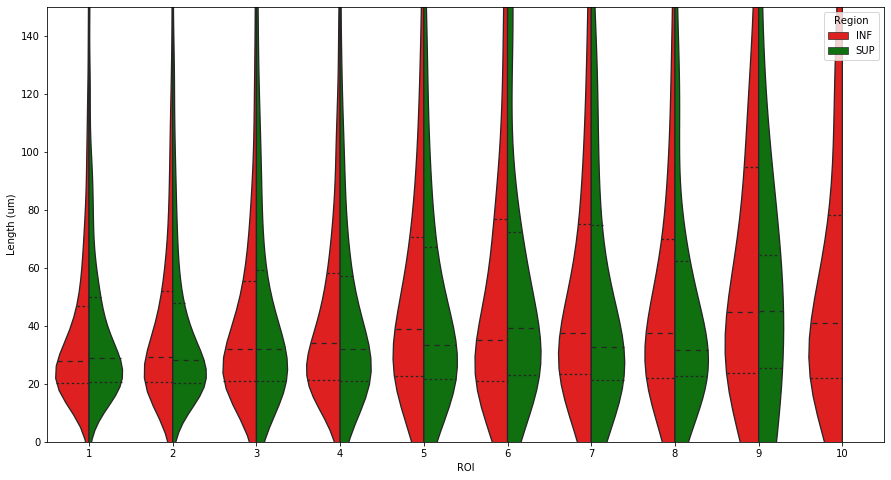

In [8]:
# Create a violin plot for the fiber length only
v_fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.violinplot(x="ROI", y="Length", hue="Region", 
               data=in_data, split=True, inner="quart", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax)
ax.set_ylabel('Length (um)')
ax.set_ylim([0, 150])
v_fig.savefig(r'length_violin_INF-SUP.png',dpi=300)

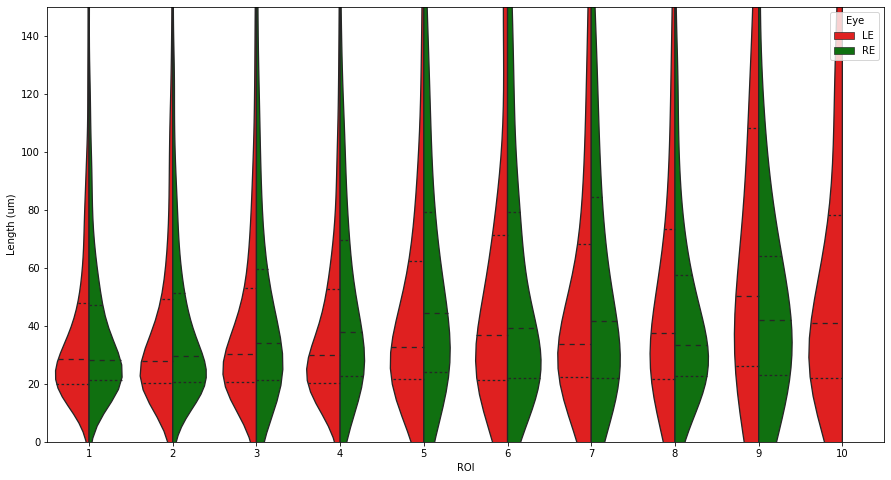

In [9]:
# Create a violin plot for the fiber length only
v_fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.violinplot(x="ROI", y="Length", hue="Eye", 
               data=in_data, split=True, inner="quart", linewidth=1.3,
               palette={"LE": "red", "RE": "green"}, ax=ax)
ax.set_ylabel('Length (um)')
ax.set_ylim([0, 150])
v_fig.savefig(r'length_violin_Eye.png',dpi=300)

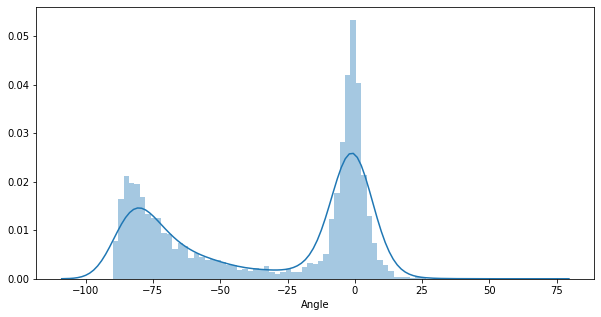

In [10]:
# Sanity check. The angles should all be between -90 to 90. I think the violin plot function is going beyond these
# limits due to the curve fit. Plot a histogram of all angles just to be sure.
#in_data['Angle'].hist(bins=100,figsize=(10,5))
hist_fig, hist_ax = plt.subplots(1,1,figsize=(10,5))
sns.distplot(in_data['Angle'],bins=75,ax=hist_ax)


Ignore the "future warning". It's fine.

The angles are in the expected range. As I suspected, the violin plots going beyond said range is due to the curve being fit by the histogram function.

Text(0, 0.5, 'Straightness')

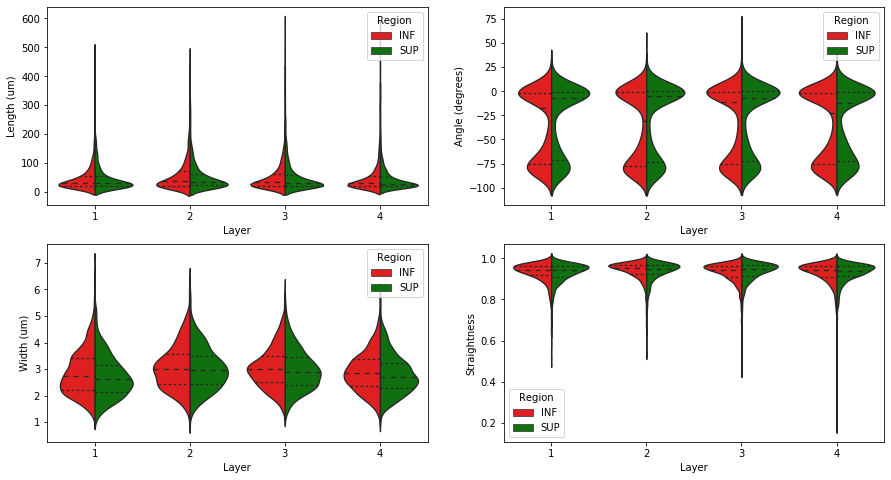

In [11]:
# Repeat the violin plots, except split by Layer, not ROI
v_fig, ax = plt.subplots(2,2,figsize=(15,8))
sns.violinplot(x="Layer", y="Length", hue="Region", 
               data=in_data, split=True, inner="quart", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[0,0])
ax[0,0].set_ylabel('Length (um)')

sns.violinplot(x="Layer", y="Angle", hue="Region", 
               data=in_data, split=True, inner="quart", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[0,1])
ax[0,1].set_ylabel('Angle (degrees)')

sns.violinplot(x="Layer", y="Width", hue="Region", 
               data=in_data, split=True, inner="quart", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[1,0])
ax[1,0].set_ylabel('Width (um)')

sns.violinplot(x="Layer", y="Straightness", hue="Region", 
               data=in_data, split=True, inner="quart", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[1,1])
ax[1,1].set_ylabel('Straightness')

Not a whole lot of difference between the Inf/Sup regions, but the distribution is definitely getting wider the further from the ONH the ROI starts. 

Also, those are some long tails. When computing the mean values for length, I should do it two different ways: using the full set of data and be first removing all values of lenght > 200

In [12]:
# Combine the data by region, ROI, and layer. Compute both the mean and standard deviation of the four parameters
# when combining
group_mean = in_data.groupby(['Region','Layer','ROI'],as_index=False).mean()

# For the version of pandas I have, there's a bug when calling the std() function during grouping. Of course.
# So here's a work-around
group_std = in_data.groupby(['Region','Layer','ROI'],as_index=False);
group_std[['Angle','Width','Length','Straightness']].apply(lambda x: x.std()); 

In [13]:
# Repeat, only keeping values of length < 200
alt_data = in_data;
alt_data['Length'].mask(alt_data['Length'] > 200,np.nan,inplace=True)
alt_data.describe() # Will see that only 34 values of Length have been dropped

,ROI,Layer,Angle,Width,Length,Straightness
count,8354.000000,8354.000000,8354.000000,8354.000000,8185.000000,8354.000000
mean,3.936438,2.552550,-33.874652,2.931153,45.560068,0.932340
std,2.383732,1.125195,36.410392,0.790644,35.481621,0.051275
min,1.000000,1.000000,-89.869752,1.012260,15.360307,0.178281
25%,2.000000,2.000000,-74.418725,2.352991,20.957050,0.915385
50%,3.000000,3.000000,-10.747480,2.862694,31.605011,0.946055
75%,5.000000,4.000000,-0.723361,3.418767,56.718598,0.965620
max,10.000000,4.000000,60.535477,6.960053,199.762785,0.999475


In [14]:
group_mean_alt = alt_data.groupby(['Region','Layer','ROI'],as_index=False).mean()
# Again, work-around for std
group_std_alt = alt_data.groupby(['Region','Layer','ROI'],as_index=False);
group_std_alt[['Angle','Width','Length','Straightness']].apply(lambda x: x.std()); 

In [15]:
# Alternative to do the grouping. May make things easier?
group_stats = in_data.groupby(['Region','Layer','ROI'],as_index=False).agg([np.mean, np.std])
group_stats_alt = alt_data.groupby(['Region','Layer','ROI'],as_index=False).agg([np.mean, np.std])

# Also want to get counts for later use
group_counts = in_data.groupby(['Region','Layer','ROI'],as_index=False).count()

group_stats.head()

Angle                Width               Length  \
                       mean        std      mean       std       mean   
Region Layer ROI                                                        
INF    1     1   -37.481017  36.620200  2.739493  0.709843  35.646417   
             2   -32.383352  37.435055  2.922980  0.783054  43.907724   
             3   -44.873000  35.774146  2.899334  0.718201  43.469448   
             4   -37.395392  35.513149  2.936092  0.863193  45.115105   
             5   -34.892358  37.241961  2.896272  0.869052  45.702802   

                            Straightness            
                        std         mean       std  
Region Layer ROI                                    
INF    1     1    25.197378     0.921587  0.061532  
             2    35.873705     0.934655  0.040868  
             3    29.097757     0.929208  0.050840  
             4    33.808145     0.931171  0.056269  
             5    32.844927     0.940298  0.043956

In [16]:
# I want to know how many fibers were in each ROI
roi_fiber_count = alt_data.groupby(['ROI'],as_index=False).count()
roi_fiber_count

,ROI,Eye,Region,Layer,Angle,Width,Length,Straightness
0,1,1296,1296,1296,1296,1296,1292,1296
1,2,1505,1505,1505,1505,1505,1494,1505
2,3,1407,1407,1407,1407,1407,1382,1407
3,4,1349,1349,1349,1349,1349,1324,1349
4,5,782,782,782,782,782,750,782
5,6,589,589,589,589,589,571,589
6,7,530,530,530,530,530,515,530
7,8,457,457,457,457,457,442,457
8,9,238,238,238,238,238,222,238
9,10,201,201,201,201,201,193,201


Text(0, 0.5, 'Length (um)')

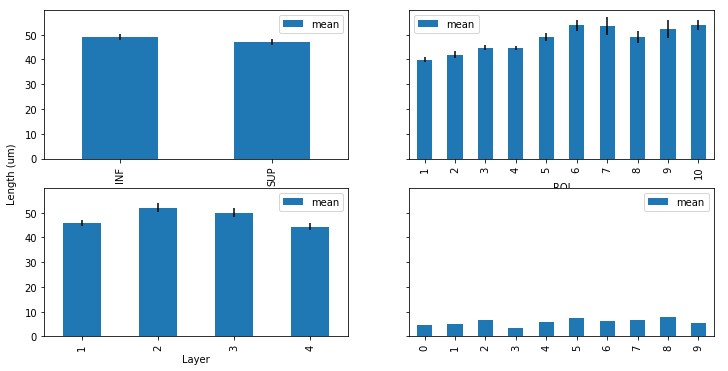

In [17]:
# Let's look at the fiber length stats first
# Using all fiber length estimates
df_length = group_stats['Length']
df_angle = group_stats['Angle']

# I'll look at the mean of the fiber lengths per region, ROI, and layer separately
# Note that the standard error is computed from the means

# By Region
len_reg = df_length.groupby(['Region'],as_index=False)['mean'].agg([np.mean, scipy.stats.sem])

# By ROI 
len_roi = df_length.groupby(['ROI'],as_index=False)['mean'].agg([np.mean, scipy.stats.sem])

# By Layer
len_layer = df_length.groupby(['Layer'],as_index=False)['mean'].agg([np.mean, scipy.stats.sem])

# Variance of the fiber angle
angle_roi = df_angle.groupby(['ROI'],as_index=False)['mean'].std()

# Create bar plots for each
len_fig, ax = plt.subplots(2,2,figsize=(12,6),sharey='all')
len_reg.plot(kind='bar',y='mean',yerr='sem',ax=ax[0,0])

len_roi.plot(kind='bar',y='mean',yerr='sem',ax=ax[0,1])

len_layer.plot(kind='bar',y='mean',yerr='sem',ax=ax[1,0])

angle_roi.plot(kind='bar',y='mean',ax=ax[1,1])

# To create a common axes label, create a new subfigure that encapsulates all the other subfigures.
# Turn off its axes and set its label.
len_fig.add_subplot(111,frame_on=False)
plt.tick_params(labelcolor='none',left=False,bottom=False)
plt.ylabel('Length (um)')

Now we're getting somewhere! There's doesn't appear to be a difference in fiber length when comparing the Inf/Sup regions. But, the fiber length seems to be increasing the further away from the ONH and decreasing from scleral layers 1->4. 

Text(0, 0.5, 'Length (um)')

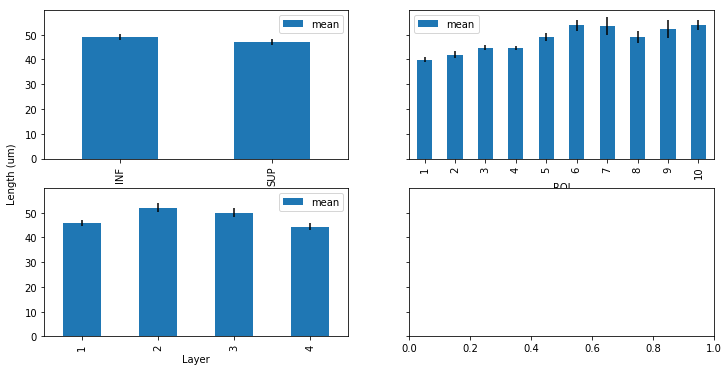

In [18]:
# Do the same thing, except use only the estimated fiber lengths < 200um
df_length = group_stats_alt['Length']

# I'll look at the mean of the fiber lengths per region, ROI, and layer separately
# Note that the standard error is computed from the means

# By Region
len_reg = df_length.groupby(['Region'],as_index=False)['mean'].agg([np.mean, scipy.stats.sem])

# By ROI 
len_roi = df_length.groupby(['ROI'],as_index=False)['mean'].agg([np.mean, scipy.stats.sem])

# By Layer
len_layer = df_length.groupby(['Layer'],as_index=False)['mean'].agg([np.mean, scipy.stats.sem])

# Create bar plots for each
len_fig, ax = plt.subplots(2,2,figsize=(12,6),sharey='all')
len_reg.plot(kind='bar',y='mean',yerr='sem',ax=ax[0,0])

len_roi.plot(kind='bar',y='mean',yerr='sem',ax=ax[0,1])

len_layer.plot(kind='bar',y='mean',yerr='sem',ax=ax[1,0])

# To create a common axes label, create a new subfigure that encapsulates all the other subfigures.
# Turn off its axes and set its label.
len_fig.add_subplot(111,frame_on=False)
plt.tick_params(labelcolor='none',left=False,bottom=False)
plt.ylabel('Length (um)')

The length of the bars changed slighlty, but there's no significant difference when excluding the very large estimated fiber lengths. For now, I'll stick with using all parameter estimates.

I'm not going to repeat the above exactly. The preceding method allowed me to add error bars. For the next plots, I'm not going to worry about that. I'll add them if I can figure out how (without a bunch of additional code)

In [19]:
group_stats.index

MultiIndex([('INF', 1,  1),
            ('INF', 1,  2),
            ('INF', 1,  3),
            ('INF', 1,  4),
            ('INF', 1,  5),
            ('INF', 1,  6),
            ('INF', 1,  7),
            ('INF', 1,  8),
            ('INF', 1,  9),
            ('INF', 1, 10),
            ('INF', 2,  1),
            ('INF', 2,  2),
            ('INF', 2,  3),
            ('INF', 2,  4),
            ('INF', 2,  5),
            ('INF', 2,  6),
            ('INF', 2,  7),
            ('INF', 2,  8),
            ('INF', 2,  9),
            ('INF', 2, 10),
            ('INF', 3,  1),
            ('INF', 3,  2),
            ('INF', 3,  3),
            ('INF', 3,  4),
            ('INF', 3,  5),
            ('INF', 3,  6),
            ('INF', 3,  7),
            ('INF', 3,  8),
            ('INF', 3,  9),
            ('INF', 3, 10),
            ('INF', 4,  1),
            ('INF', 4,  2),
            ('INF', 4,  3),
            ('INF', 4,  4),
            ('INF', 4,  5),
            ('INF', 

In [20]:
sub_data = in_data.groupby(['Region','ROI','Layer'],as_index=False).mean()

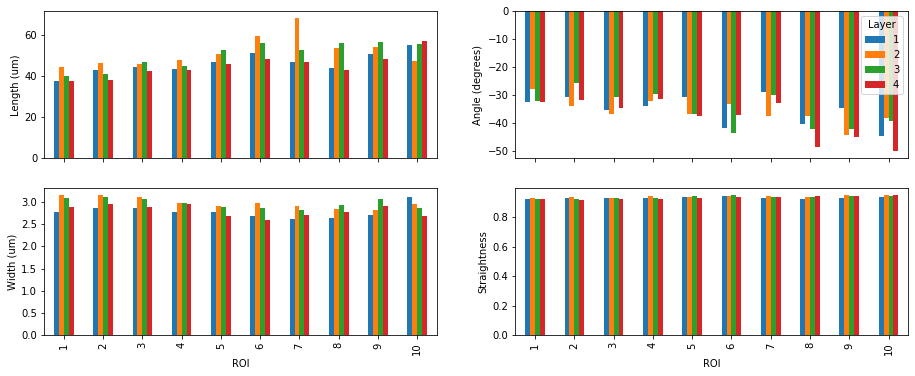

In [21]:
# Create smaller data frames that can be later pivoted.
ld = sub_data[['ROI','Layer','Length']]
ad = sub_data[['ROI','Layer','Angle']]
wd = sub_data[['ROI','Layer','Width']]
sd = sub_data[['ROI','Layer','Straightness']]

ldp = ld.pivot_table(index='ROI',columns='Layer',values='Length')
adp = ad.pivot_table(index='ROI',columns='Layer',values='Angle')
wdp = wd.pivot_table(index='ROI',columns='Layer',values='Width')
sdp = sd.pivot_table(index='ROI',columns='Layer',values='Straightness')

gs = dict(left=0.1, right=0.9, bottom=0.05, top=0.95)
bar_fig, (ax) = plt.subplots(2,2,figsize=(15,5),sharex='all',gridspec_kw=gs)
ldp.plot.bar(ax=ax[0,0])
adp.plot.bar(ax=ax[0,1])
wdp.plot.bar(ax=ax[1,0])
sdp.plot.bar(ax=ax[1,1])

ax[0,0].set_ylabel(r'Length (um)')
ax[0,1].set_ylabel(r'Angle (degrees)')
ax[1,0].set_ylabel(r'Width (um)')
ax[1,1].set_ylabel(r'Straightness')

ax[0,0].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()

bar_fig.savefig(r'.\fiber_bar_all_params.png',dpi=300)

What we're looking at are plots of the four parameters split up by ROI, and within each ROI split by layer. Note this combines the Inf/Sup regions. Looking specifically at fiber length, one can still see that the length tends to increase from ROI 1->4 and decreases across layers within an ROI. 

I want to point out that for the fiber angle, there is a value for layer 1 in ROI 4, it's just very small:
(This comment made sense before I switched to using the magnitude of the angle)

In [22]:
adp.head()

Layer,1,2,3,4
ROI,,,,
1,-32.567866,-28.049998,-32.235524,-32.550931
2,-30.753579,-33.862718,-25.583293,-31.850884
3,-35.586462,-36.773400,-30.905193,-34.818850
4,-34.123907,-32.151367,-29.725661,-31.355944
5,-30.733095,-36.736421,-36.937319,-37.402835


# Comparing left/right eyes

The preceding results contain some useful information, but the analysis was more an exercise for me to get better acquainted with using Python/pandas. 

I'm going to redo some of the analysis and add to it, in part by comparing left (control) and right (myopic) eyes.

In [23]:
# Read in the data again to get the 'Eye' column back
in_data = pd.read_csv(file_name) # read in the data
pix_to_um = 0.512 # the SHG images have a resolution of 0.512um/pixel 

# Convert the length and width values to microns
in_data['Length'] *= pix_to_um
in_data['Width'] *= pix_to_um

le_data = in_data[in_data['Eye'] == 'LE']
re_data = in_data[in_data['Eye'] == 'RE']

In [24]:
le_group = le_data.groupby(['Region','ROI','Layer'],as_index=False).mean()
re_group = re_data.groupby(['Region','ROI','Layer'],as_index=False).mean()

inf_data = in_data[in_data['Region'] == 'INF'].groupby(['Eye','ROI','Layer'],as_index=False).mean()
sup_data = in_data[in_data['Region'] == 'SUP'].groupby(['Eye','ROI','Layer'],as_index=False).mean()


le_group_counts = le_data.groupby(['Region','ROI','Layer'],as_index=False).count()
re_group_counts = re_data.groupby(['Region','ROI','Layer'],as_index=False).count()
print(le_group_counts.iloc[0,:])
print('\n')
print(le_group.iloc[0,:])

Region          INF
ROI               1
Layer             1
Eye              81
Angle            81
Width            81
Length           81
Straightness     81
Name: 0, dtype: object


Region               INF
ROI                    1
Layer                  1
Angle           -41.9622
Width             2.8247
Length           33.6742
Straightness    0.923627
Name: 0, dtype: object


The groupby() function coupled with the mean() function, as I have implemented it, computed the mean of the fiber angle, length, width, and straightness for each layer, within in ROI 1, within each INF/SUP region. For example, in the left eye, INF region, ROI 1, and layer 1, there were 152 fibers with average length 47.7 um. 

I want to make clear what the groupby() function is doing because I'll be working with this data in most instances.

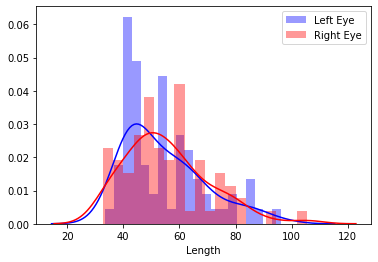

In [25]:
# Quick plot of the histogram of fiber lengths for the left and right eyes
sns.distplot(le_group['Length'],bins=20,color='blue',label='Left Eye')
sns.distplot(re_group['Length'],bins=20,color='red',label='Right Eye')
plt.legend()

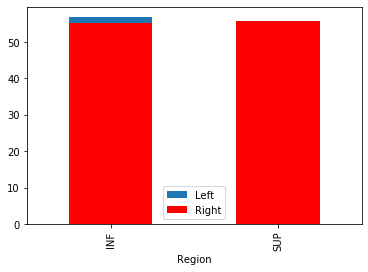

In [26]:
this_ax = le_group.groupby(['Region']).mean().plot.bar(y='Length',label='Left')
re_group.groupby(['Region']).mean().plot.bar(y='Length',color='red',ax=this_ax,label='Right')

In [27]:
# The mean fiber length appears to larger generally in the left eye, and larger in the superior region for both
print(re_group.groupby(['Region']).mean())
print('\n')
print(le_group.groupby(['Region']).mean())

        ROI  Layer      Angle     Width     Length  Straightness
Region                                                          
INF     5.0    2.5 -30.634655  2.775149  55.095546      0.937301
SUP     5.0    2.5 -34.484833  2.719284  55.717934      0.936307


        ROI  Layer      Angle     Width     Length  Straightness
Region                                                          
INF     5.5    2.5 -39.254894  3.053873  56.849796      0.935998
SUP     4.5    2.5 -33.032253  2.895742  51.426638      0.935527


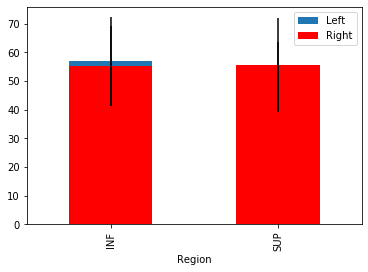

In [28]:
this_ax = le_group.groupby(['Region']).agg([np.mean, np.std])['Length'].plot.bar(y='mean',yerr='std',label='Left')
re_group.groupby(['Region']).agg([np.mean, np.std])['Length'].plot.bar(y='mean',yerr='std',label='Right',ax=this_ax,color='red')

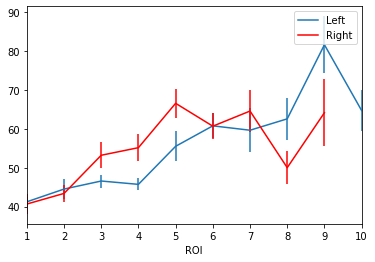

In [29]:
# Not the best visual. I can't figure out how to put the bars side by side for each region so I can see the individual
# error bars.
# Whatever, not important for now. Let's look at the difference in fiber length by ROI and layer, comparing
# left and right eyes
this_ax = le_group.groupby(['ROI'])['Length'].agg([np.mean, scipy.stats.sem]).plot.line(y='mean',yerr='sem',label='Left')
re_group.groupby(['ROI'])['Length'].agg([np.mean, scipy.stats.sem]).plot.line(y='mean',yerr='sem',label='Right',color='red',ax=this_ax)

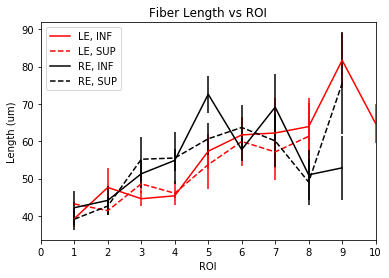

In [30]:
# Interesting, the fiber length appears to more increase more rapidly as the ROIs get further from the ONH
# Given, that, I want to figure out how to plot four lines, to split the fiber length by eye and region, not just eye

le_agg = le_group.groupby(['Region','ROI'])['Length'].agg([np.mean, scipy.stats.sem])
re_agg = re_group.groupby(['Region','ROI'])['Length'].agg([np.mean, scipy.stats.sem])

this_ax = le_agg.loc['INF'].plot.line(y='mean',yerr='sem',label='LE, INF',color='red',linestyle='-')
le_agg.loc['SUP'].plot.line(y='mean',yerr='sem',label='LE, SUP',color='red',ax=this_ax,linestyle='--');
re_agg.loc['INF'].plot.line(y='mean',yerr='sem',label='RE, INF',color='black',ax=this_ax,linestyle='-');
re_agg.loc['SUP'].plot.line(y='mean',yerr='sem',label='RE, SUP',color='black',ax=this_ax,linestyle='--')
this_ax.set_xticks(np.arange(11));
this_ax.set_ylabel('Length (um)')
this_ax.set_title('Fiber Length vs ROI')
this_fig = this_ax.get_figure()
this_fig.savefig(r'.\length_vs_roi.png',dpi=300)

The gradient for fiber increase as the ROIs get further from the ROI seems to be larger for the right eyes. However, the results are definitely skewed because of the large ROI size. I'll keep this in mind when I redo the analysis with smaller ROIs. 

Going to repeat the above plots except grouping by layer, not ROI

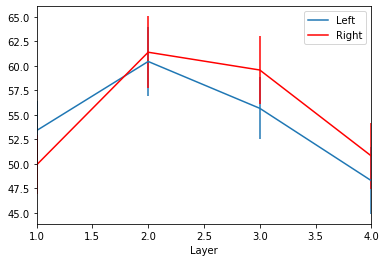

In [31]:

this_ax = le_group.groupby(['Layer'])['Length'].agg([np.mean, scipy.stats.sem]).plot.line(y='mean',yerr='sem',label='Left')
re_group.groupby(['Layer'])['Length'].agg([np.mean, scipy.stats.sem]).plot.line(y='mean',yerr='sem',label='Right',color='red',ax=this_ax)

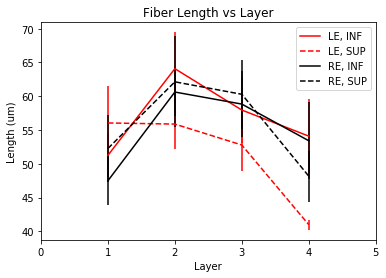

In [32]:
le_agg = le_group.groupby(['Region','Layer'])['Length'].agg([np.mean, scipy.stats.sem])
re_agg = re_group.groupby(['Region','Layer'])['Length'].agg([np.mean, scipy.stats.sem])

this_ax = le_agg.loc['INF'].plot.line(y='mean',yerr='sem',label='LE, INF',color='red',linestyle='-')
le_agg.loc['SUP'].plot.line(y='mean',yerr='sem',label='LE, SUP',color='red',ax=this_ax,linestyle='--');
re_agg.loc['INF'].plot.line(y='mean',yerr='sem',label='RE, INF',color='black',ax=this_ax,linestyle='-');
re_agg.loc['SUP'].plot.line(y='mean',yerr='sem',label='RE, SUP',color='black',ax=this_ax,linestyle='--')
this_ax.set_xticks(np.arange(6));
this_ax.set_ylabel('Length (um)')
this_ax.set_title('Fiber Length vs Layer')
this_fig = this_ax.get_figure()
this_fig.savefig(r'.\length_vs_layer.png',dpi=300)

Huh, wasn't expecting that. Much more significant decrease if fiber length from layer 1 -> layer 4 for the left eye.
What's more interesting the the very slight, perhaps no significant change across layers for the inferior region of both eyes. The largest gradient in fiber length across layers is for the LE-SUP, followed by RE-SUP

In [33]:
le_agg.head()

mean       sem
Region Layer                     
INF    1      51.257546  3.200534
       2      64.083775  5.394503
       3      57.957717  4.856094
       4      54.100144  5.494486
SUP    1      56.050360  5.464075

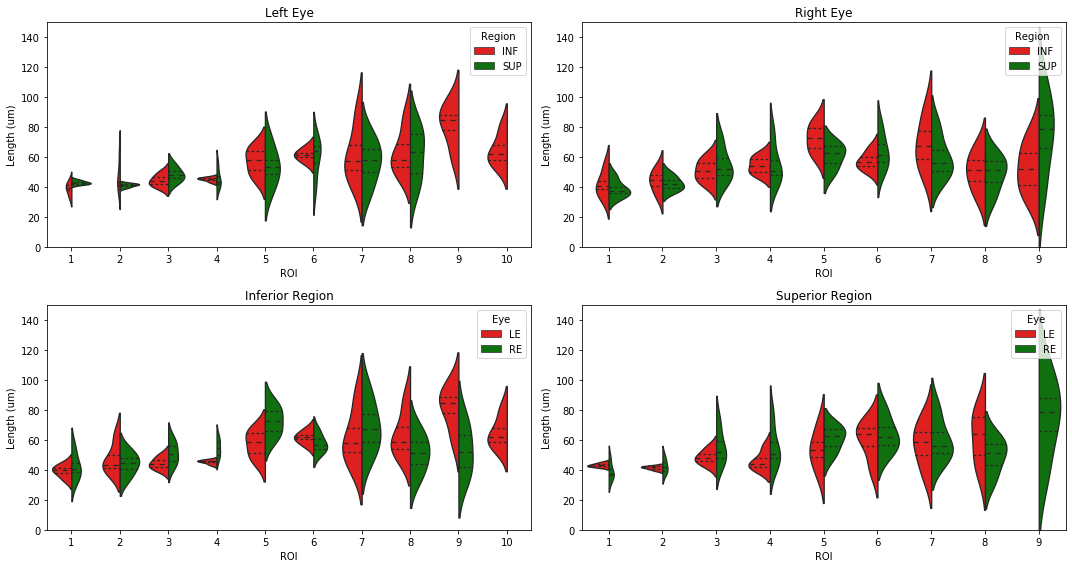

In [34]:
v_fig, ax = plt.subplots(2,2,figsize=(15,8))
sns.violinplot(x="ROI", y="Length", hue="Region", 
               data=le_group, split=True, inner="quartile", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[0,0])
ax[0,0].set_ylabel('Length (um)')
ax[0,0].set_ylim([0, 150])
ax[0,0].set_title('Left Eye')

sns.violinplot(x="ROI", y="Length", hue="Region", 
               data=re_group, split=True, inner="quartile", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[0,1])
ax[0,1].set_ylabel('Length (um)')
ax[0,1].set_ylim([0, 150])
ax[0,1].set_title('Right Eye')

sns.violinplot(x="ROI", y="Length", hue="Eye", 
               data=inf_data, split=True, inner="quartile", linewidth=1.3,
               palette={"LE": "red", "RE": "green"}, ax=ax[1,0])
ax[1,0].set_ylabel('Length (um)')
ax[1,0].set_ylim([0, 150])
ax[1,0].set_title('Inferior Region')

sns.violinplot(x="ROI", y="Length", hue="Eye", 
               data=sup_data, split=True, inner="quartile", linewidth=1.3,
               palette={"LE": "red", "RE": "green"}, ax=ax[1,1])
ax[1,1].set_ylabel('Length (um)')
ax[1,1].set_ylim([0, 150])
ax[1,1].set_title('Superior Region')

v_fig.tight_layout()
v_fig.savefig(r'.\violin_plot_length_misc.png',dpi=300)


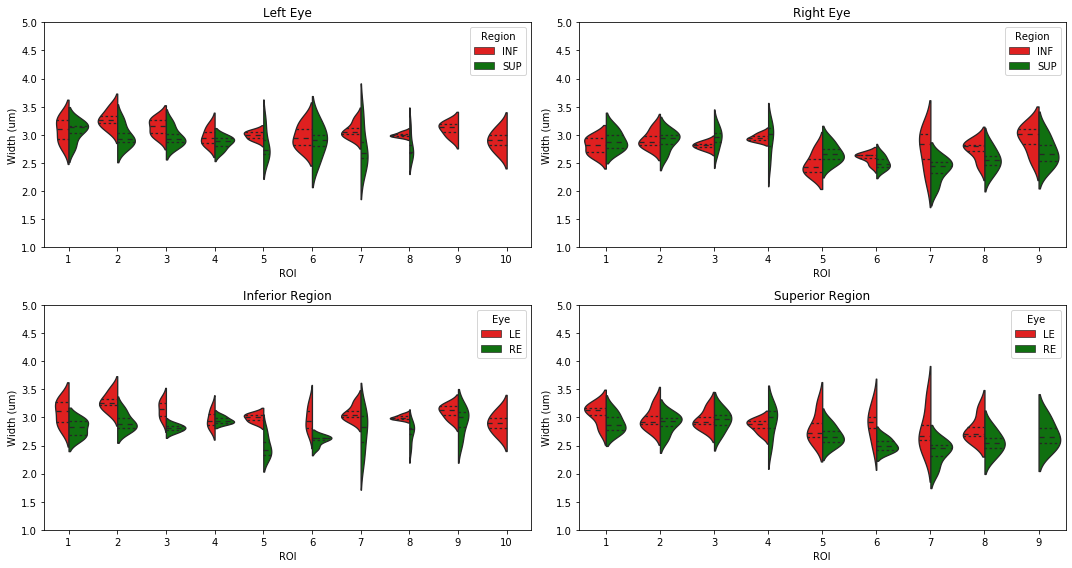

In [35]:
v_fig, ax = plt.subplots(2,2,figsize=(15,8))
sns.violinplot(x="ROI", y="Width", hue="Region", 
               data=le_group, split=True, inner="quartile", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[0,0])
ax[0,0].set_ylabel('Width (um)')
ax[0,0].set_ylim([1, 5])
ax[0,0].set_title('Left Eye')

sns.violinplot(x="ROI", y="Width", hue="Region", 
               data=re_group, split=True, inner="quartile", linewidth=1.3,
               palette={"INF": "red", "SUP": "green"}, ax=ax[0,1])
ax[0,1].set_ylabel('Width (um)')
ax[0,1].set_ylim([1, 5])
ax[0,1].set_title('Right Eye')

sns.violinplot(x="ROI", y="Width", hue="Eye", 
               data=inf_data, split=True, inner="quartile", linewidth=1.3,
               palette={"LE": "red", "RE": "green"}, ax=ax[1,0])
ax[1,0].set_ylabel('Width (um)')
ax[1,0].set_ylim([1, 5])
ax[1,0].set_title('Inferior Region')

sns.violinplot(x="ROI", y="Width", hue="Eye", 
               data=sup_data, split=True, inner="quartile", linewidth=1.3,
               palette={"LE": "red", "RE": "green"}, ax=ax[1,1])
ax[1,1].set_ylabel('Width (um)')
ax[1,1].set_ylim([1, 5])
ax[1,1].set_title('Superior Region')

v_fig.tight_layout()
v_fig.savefig(r'.\violin_plot_width_misc.png',dpi=300)

In [36]:
# Count the number of fibers per eye, region, roi, and layer
eye_count = in_data.groupby(['Eye']).count()
region_count = in_data.groupby(['Region']).count()
roi_count = in_data.groupby(['ROI']).count()
layer_count = in_data.groupby(['Layer']).count()

layer_count.head()

,Eye,Region,ROI,Angle,Width,Length,Straightness
Layer,,,,,,,
1,2023,2023,2023,2023,2023,2023,2023
2,1924,1924,1924,1924,1924,1924,1924
3,2175,2175,2175,2175,2175,2175,2175
4,2232,2232,2232,2232,2232,2232,2232


In [37]:
print(eye_count['Length'])
print('\n')
print(region_count['Length'])
print('\n')
print(roi_count['Length'])
print('\n')
print(layer_count['Length'])

Eye
LE    5053
RE    3301
Name: Length, dtype: int64


Region
INF    4841
SUP    3513
Name: Length, dtype: int64


ROI
1     1296
2     1505
3     1407
4     1349
5      782
6      589
7      530
8      457
9      238
10     201
Name: Length, dtype: int64


Layer
1    2023
2    1924
3    2175
4    2232
Name: Length, dtype: int64


In [63]:
le_roi_group = le_group.groupby(['ROI']).agg([np.mean, np.std])
le_roi_count = le_group.groupby(['ROI']).count()

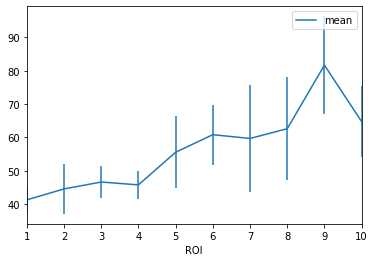

In [55]:
le_roi_group['Length'].plot.line(y='mean',yerr='std')

In [79]:
le_roi_group['Length']['mean']
le_group_counts.groupby('ROI').sum()['Length']

ROI
1     704
2     806
3     838
4     848
5     499
6     364
7     339
8     298
9     156
10    201
Name: Length, dtype: int64

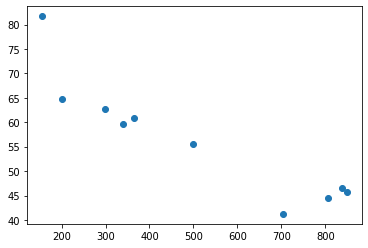

In [80]:
le_group_counts.groupby('ROI').sum()
plt.figure()
plt.scatter(le_group_counts.groupby('ROI').sum()['Length'],le_roi_group['Length']['mean'])

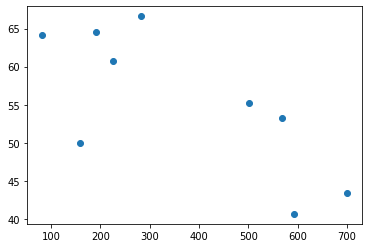

In [83]:
plt.figure()
plt.scatter(re_group_counts.groupby('ROI').sum()['Length'],re_group.groupby('ROI').mean()['Length'])

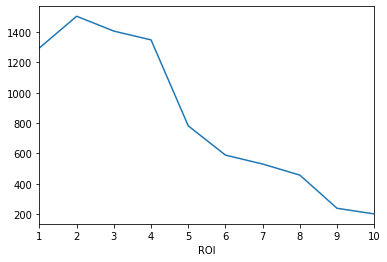

In [87]:
in_data.groupby('ROI').count()['Length'].plot.line()

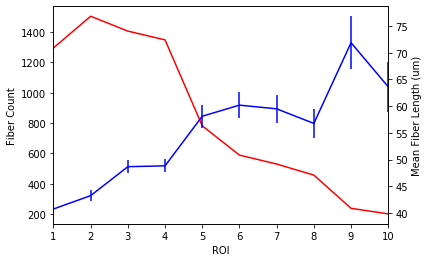

In [93]:
# Create a plot of the fiber counts and length for all data. On the same axes with split y-axis 

fig, ax1 = plt.subplots()

ax1.set_xlabel('ROI')
ax1.set_ylabel('Fiber Count')
in_data.groupby('ROI').count()['Length'].plot.line(ax=ax1,color='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Mean Fiber Length (um)')
mean_err = in_data.groupby('ROI').agg([scipy.stats.sem])
in_data.groupby('ROI').mean()['Length'].plot.line(ax=ax2,yerr=mean_err,color='blue')


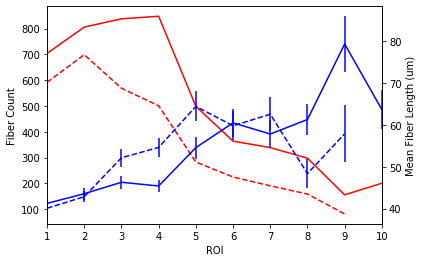

In [115]:
# Create a plot the show the fiber counts and mean length. Split by LE/RE, so four curves total
le_data = in_data.loc[in_data['Eye']=='LE']
re_data = in_data.loc[in_data['Eye']=='RE']

fig, ax1 = plt.subplots()

ax1.set_xlabel('ROI')
ax1.set_ylabel('Fiber Count')
le_data.groupby('ROI').count()['Length'].plot.line(ax=ax1,color='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Mean Fiber Length (um)')
le_mean_err = le_data.groupby('ROI').agg([scipy.stats.sem])
le_data.groupby('ROI').mean()['Length'].plot.line(ax=ax2,yerr=le_mean_err,color='blue')

re_data.groupby('ROI').count()['Length'].plot.line(ax=ax1,color='red',linestyle='--')
re_mean_err = re_data.groupby('ROI').agg([scipy.stats.sem])
re_data.groupby('ROI').mean()['Length'].plot.line(ax=ax2,yerr=re_mean_err,color='blue',linestyle='--')
